Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Hurricane Irma Data

In [2]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/hurricane_irma_2017_train.tsv"
dev_path = "/content/hurricane_irma_2017_dev.tsv"
test_path = "/content/hurricane_irma_2017_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [3]:
train_df

,tweet_id,tweet_text,class_label
0,906347001712926721,An inside look at what its like inside a shelt...,displaced_people_and_evacuations
1,908729925905068032,Our parent company @Realogy is matching $75K f...,rescue_volunteering_or_donation_effort
2,907080161513889792,UNICEF is working to bring safe water &amp; sa...,other_relevant_information
3,906964492193595392,Hurricane Irma ripping entire roofs off buildi...,infrastructure_and_utility_damage
4,907227218593685506,Cosmic Kamer on @richardbranson as he reveals ...,infrastructure_and_utility_damage
...,...,...,...
7532,905552454678454272,Flash Flood Warnings have been issued for part...,caution_and_advice
7533,908418434475724801,Water continues to flood northbound Three Oaks...,infrastructure_and_utility_damage
7534,909170746869420032,"Irma Roars Into Georgia, Leaving at Least 1 De...",injured_or_dead_people
7535,907367567727226880,We can help #HurricaneIrma victims by giving b...,rescue_volunteering_or_donation_effort


In [4]:
test_df

,tweet_id,tweet_text,class_label
0,907771445132095488,"Armed with a chainsaw and a charitable spirit,...",other_relevant_information
1,908018116894117889,#StormAileen is bringing #rain in across the w...,caution_and_advice
2,908428954570289154,Tonight in our service we will be collecting t...,other_relevant_information
3,905951544289447936,Its not raining yet but we know you are gettin...,sympathy_and_support
4,905750912702001152,"#Irma update 2: Already, 10 people are dead in...",injured_or_dead_people
...,...,...,...
1857,908186413321121792,Shame to hear that 8 elderly people are dead a...,injured_or_dead_people
1858,905725141501579264,BREAKING: Hurricane Irma kills 9 in Caribbean ...,injured_or_dead_people
1859,909448166856065024,In #Florida #AnnaMariaIsland #HurricaneIrmaAft...,other_relevant_information
1860,905931554551205888,"Britain sends $15.7 million, ship to assist Ir...",other_relevant_information


ALL DATA

In [5]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
tweet_data['class_label'].value_counts()

,count
class_label,
other_relevant_information,2358
infrastructure_and_utility_damage,1881
rescue_volunteering_or_donation_effort,1590
injured_or_dead_people,894
displaced_people_and_evacuations,755
not_humanitarian,615
caution_and_advice,613
sympathy_and_support,567
requests_or_urgent_needs,126


Data Preprocessing

In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [9]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

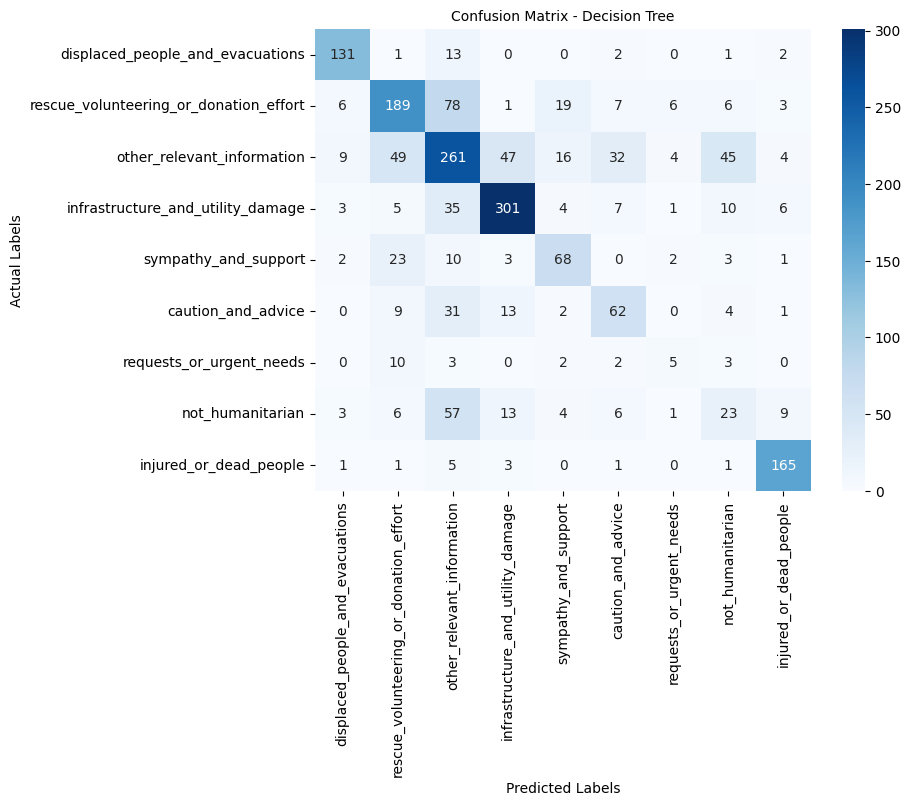


Decision Tree Evaluation:
Accuracy: 0.6471535982814178
Precision: 0.6388793571908821
F1 Score: 0.6423446748642384

 Classification Report:
                                        precision    recall  f1-score   support

      displaced_people_and_evacuations       0.85      0.87      0.86       150
rescue_volunteering_or_donation_effort       0.65      0.60      0.62       315
            other_relevant_information       0.53      0.56      0.54       467
     infrastructure_and_utility_damage       0.79      0.81      0.80       372
                  sympathy_and_support       0.59      0.61      0.60       112
                    caution_and_advice       0.52      0.51      0.51       122
              requests_or_urgent_needs       0.26      0.20      0.23        25
                      not_humanitarian       0.24      0.19      0.21       122
                injured_or_dead_people       0.86      0.93      0.90       177

                              accuracy                    

In [12]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

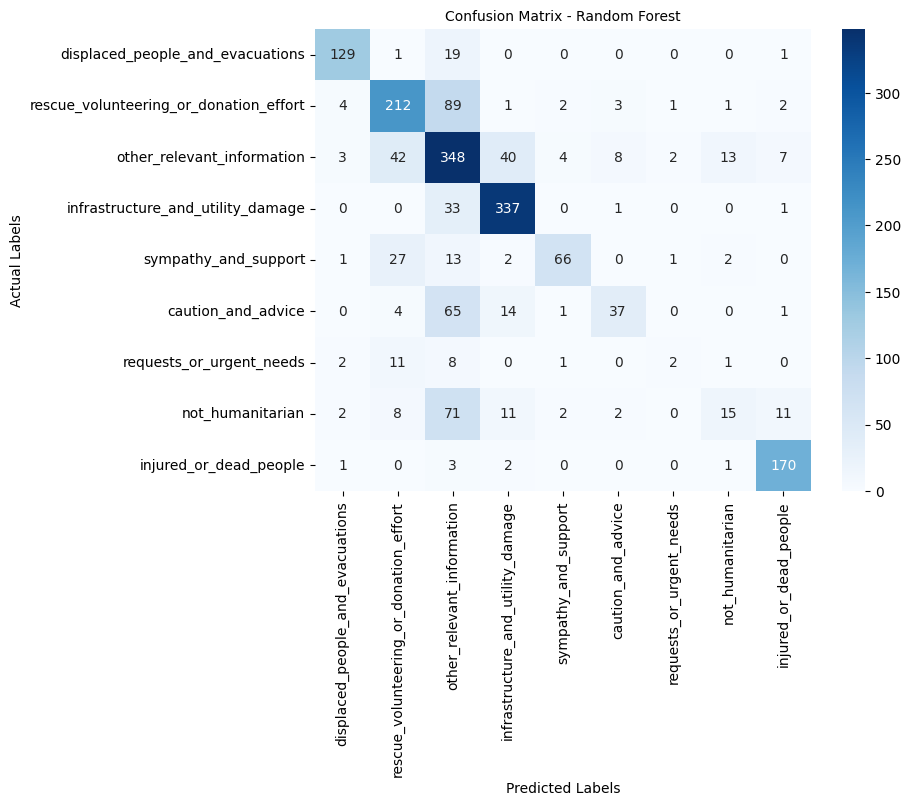


Random Forest Evaluation:
Accuracy: 0.706766917293233
Precision: 0.7084401283599276
F1 Score: 0.6881688151790866

 Classification Report:
                                        precision    recall  f1-score   support

      displaced_people_and_evacuations       0.91      0.86      0.88       150
rescue_volunteering_or_donation_effort       0.70      0.67      0.68       315
            other_relevant_information       0.54      0.75      0.62       467
     infrastructure_and_utility_damage       0.83      0.91      0.87       372
                  sympathy_and_support       0.87      0.59      0.70       112
                    caution_and_advice       0.73      0.30      0.43       122
              requests_or_urgent_needs       0.33      0.08      0.13        25
                      not_humanitarian       0.45      0.12      0.19       122
                injured_or_dead_people       0.88      0.96      0.92       177

                              accuracy                     

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

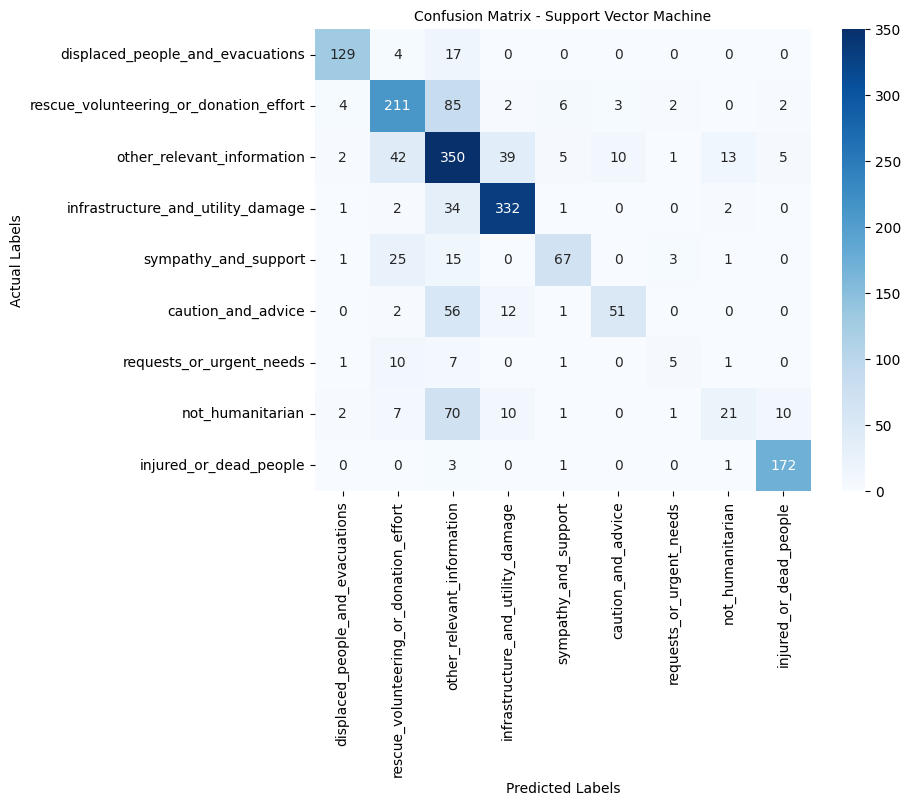


Support Vector Machine Evaluation:
Accuracy: 0.7185821697099892
Precision: 0.7259125727036481
F1 Score: 0.7065013920938875

 Classification Report:
                                        precision    recall  f1-score   support

      displaced_people_and_evacuations       0.92      0.86      0.89       150
rescue_volunteering_or_donation_effort       0.70      0.67      0.68       315
            other_relevant_information       0.55      0.75      0.63       467
     infrastructure_and_utility_damage       0.84      0.89      0.87       372
                  sympathy_and_support       0.81      0.60      0.69       112
                    caution_and_advice       0.80      0.42      0.55       122
              requests_or_urgent_needs       0.42      0.20      0.27        25
                      not_humanitarian       0.54      0.17      0.26       122
                injured_or_dead_people       0.91      0.97      0.94       177

                              accuracy           

In [14]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")